# Motifs pipeline

This notbooks shows how to use the Motif Pipeline. The Motif pipeline transforms a corpus to motif-based features, or other UDPipe tokens, such as POS, lemma, etc. It consists of 4 steps:
- UDPipe tokenization of the corpus
- tokens preprocessing with n-gram transformation
- n-grams featurization, for example: TFIDF or TF
- visualization, for example: PCA analysis, distributional plots, specificity analysis.


## Inputs variables
- `corpus_dir`: If you run this notebook for the first time, you need to pass
the corpus_dir as parameter in order to annotate the corpus and create the
tokens.
- otherwiswe, give the `tokens_dir` as argument.
- `token_type`: Define the token type of interest, `AVAILABLE_TOKEN_TYPES = ["text", "lemma", "pos", "motif"]`
- `feature`: Define the feature on which to perform PCA analysis
- `n`: n-gram length

In [1]:
from motifs.config import PKG_DATA_PATH

# Define the path of the corpus
corpus_dir = PKG_DATA_PATH.joinpath('corpus_test')
tokens_dir = None
# tokens_dir = "../data/canon/tokens_canon"
# corpus_dir = None
# Define the token type: AVAILABLE_TOKEN_TYPES = ["text", "lemma", "pos", "motif"]
token_type = "motif"
# Define the feature on which to perform PCA analysis
feature = {"name": "tfidf", "params": {"normalize": True, "smartirs": "nfc"}}
# Please check gensim doc for the parameters definition. SMARTIRS
# corresponds to the standard notation available at https://en.wikipedia.org/wiki/SMART_Information_Retrieval_System
# n-gram length
n = 4

# Import librairies

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from motifs.pipeline import Pipeline
from motifs.plots import plot_motif_histogram, plot_tf_idf
from motifs.pca import pca_transform
import time

# Create pipeline object and perform annotation

In [3]:
pipeline = Pipeline(token_type, corpus_dir=corpus_dir, tokens_dir=tokens_dir, save=False)

[PyMotifs-Logger:tokenizer.py:299] - [5610] - 2024-02-28 18:04:40 - DEBUG - Steps to go 3: tokenizing Huysmans-Rebours.txt...
[PyMotifs-Logger:tokenizer.py:317] - [5610] - 2024-02-28 18:04:42 - DEBUG - Done with Huysmans-Rebours.txt in 2.26 seconds.
[PyMotifs-Logger:tokenizer.py:299] - [5610] - 2024-02-28 18:04:42 - DEBUG - Steps to go 2: tokenizing Flaubert-Bovary.txt...
[PyMotifs-Logger:tokenizer.py:317] - [5610] - 2024-02-28 18:04:45 - DEBUG - Done with Flaubert-Bovary.txt in 2.33 seconds.
[PyMotifs-Logger:tokenizer.py:299] - [5610] - 2024-02-28 18:04:45 - DEBUG - Steps to go 1: tokenizing Balzac-Goriot.txt...
[PyMotifs-Logger:tokenizer.py:317] - [5610] - 2024-02-28 18:04:47 - DEBUG - Done with Balzac-Goriot.txt in 2.71 seconds.


# Transform tokens to n-grams and present simple statistics

[PyMotifs-Logger:features.py:50] - [6324] - 2024-02-28 18:04:49 - DEBUG - Steps to go 2
[PyMotifs-Logger:features.py:50] - [6325] - 2024-02-28 18:04:49 - DEBUG - Steps to go 1
[PyMotifs-Logger:features.py:50] - [6323] - 2024-02-28 18:04:49 - DEBUG - Steps to go 3


Execution time: 1.7887 secs


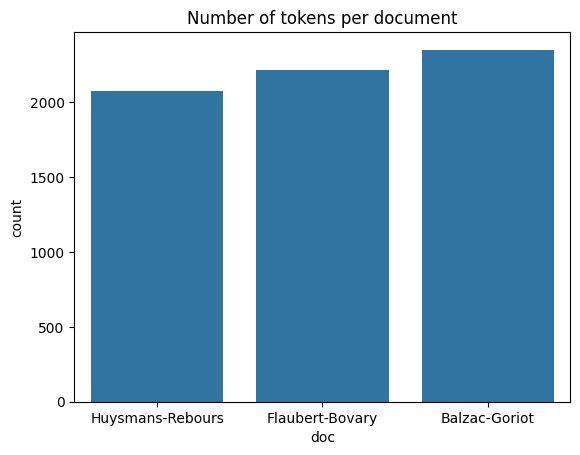

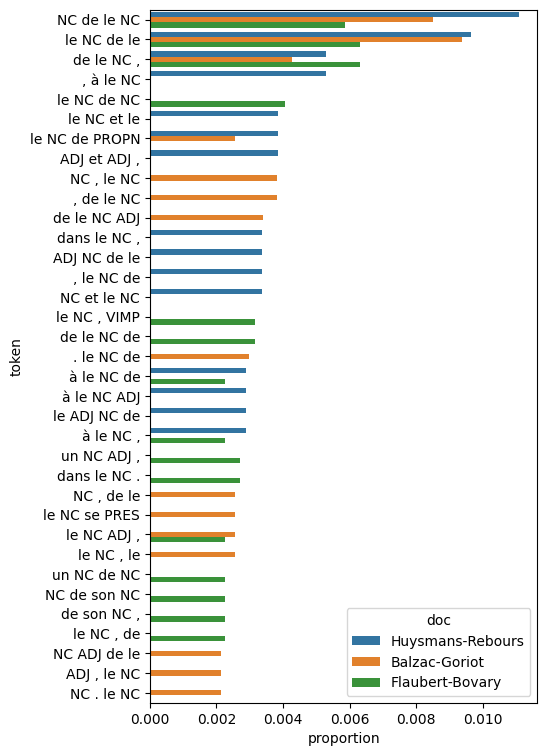

In [4]:
t1 = time.time()
# Transform to n_grams
pipeline.transform_to_ngrams(n)
t2 = time.time()
print(f"Execution time: {t2 - t1:.4f} secs")
## Number of tokens per document
sns.countplot(pipeline.ngrams, x="doc")
plt.title("Number of tokens per document")

# Plot distribution of tokens
plot_motif_histogram(pipeline.ngrams, stat="proportion", n_tokens=15, plot_type="group")

# Compute features

In this example, we use tfidf features and we plot the most frequent ones

/Users/brunospilak/miniconda3/envs/pymotifs/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


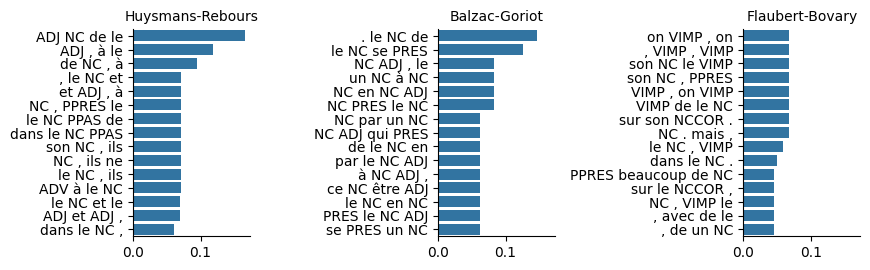

In [5]:
tfidf = pipeline.get_features(feature)
plot_tf_idf(tfidf, n_tokens=15, plot_type="sep")

# Principal Component Analysis


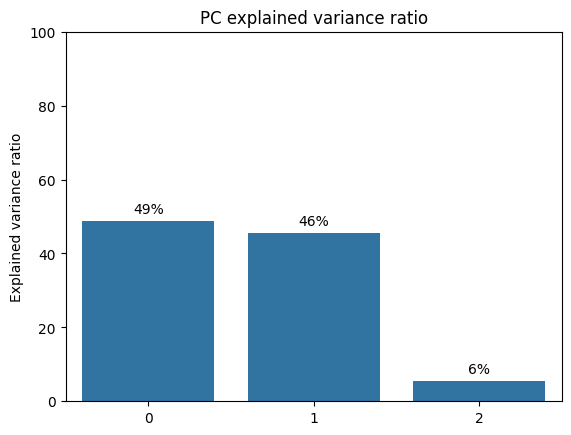

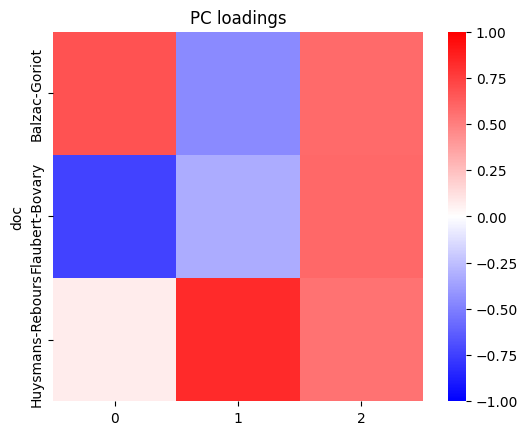

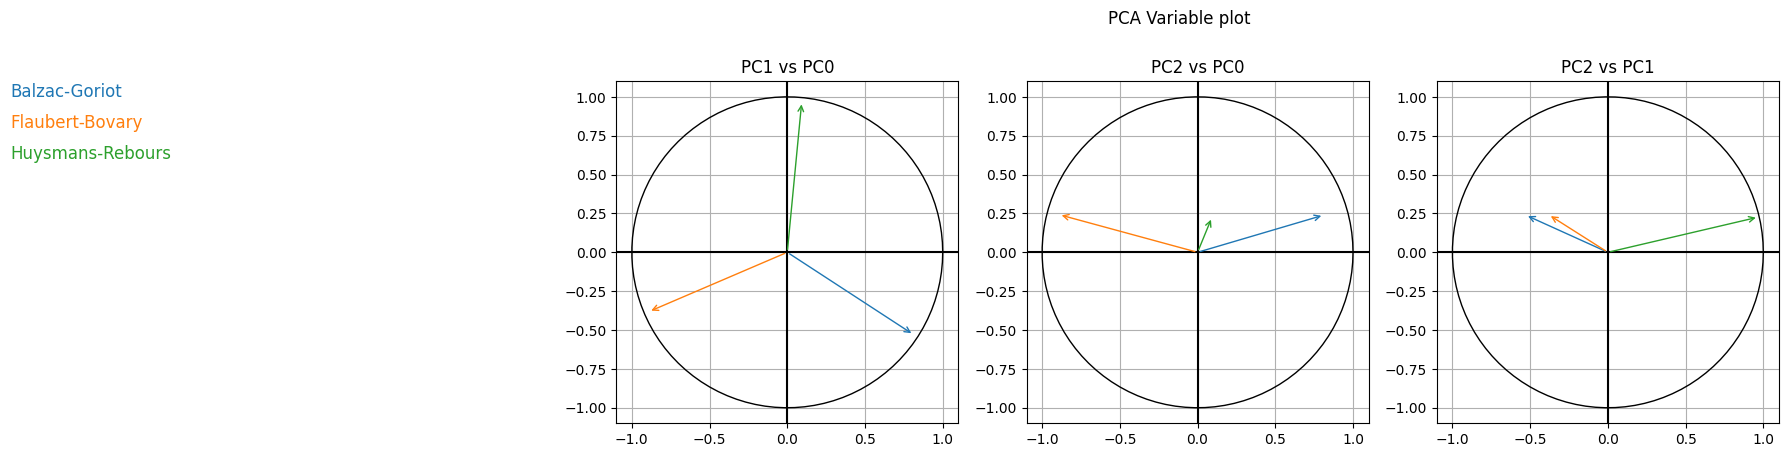

In [6]:
pca = pca_transform(
    tfidf.pivot_table(
        index="token", columns=["doc"], values=feature["name"]
    ), 
    plot=True
)

- We observe that the first two principal components (PC) explains 95% of the variance:
    - the first component explains both Flaubert-Bovary and Balzac-Goriot, but not Huysmans-Rebours
    - the second one explains very well Huysmans-Rebours
- Balzac-Goriot is positively correlated with the first PC
- Flaubert-Bovary is negatively correlated with the first PC
- Huysmans-Rebours is positvely correated with the second PC.
- Balzac-Goriot and Flaubert-Bovary are negatively correlated with the second PC.
- We observe that the first PC can be used to separate Flaubert-Bovary from Balzac-Goriot, while the second PC can be used to separate Huysmans-Rebours from Flaubert-Bovary and Balzac-Goriot.

# We can also execute the featurization and PCA in one call

[PyMotifs-Logger:features.py:50] - [6325] - 2024-02-28 18:05:01 - DEBUG - Steps to go 2
[PyMotifs-Logger:features.py:50] - [6327] - 2024-02-28 18:05:02 - DEBUG - Steps to go 3
[PyMotifs-Logger:features.py:50] - [6328] - 2024-02-28 18:05:02 - DEBUG - Steps to go 1


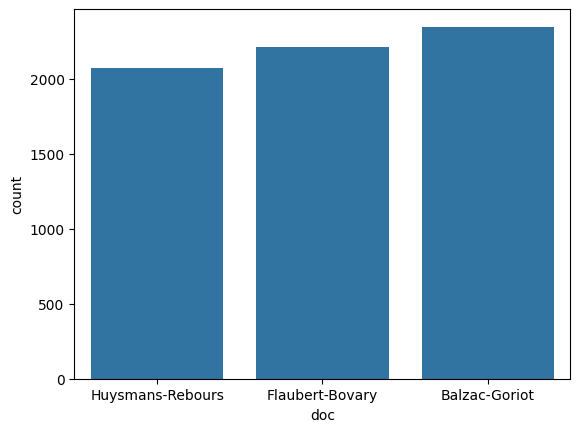

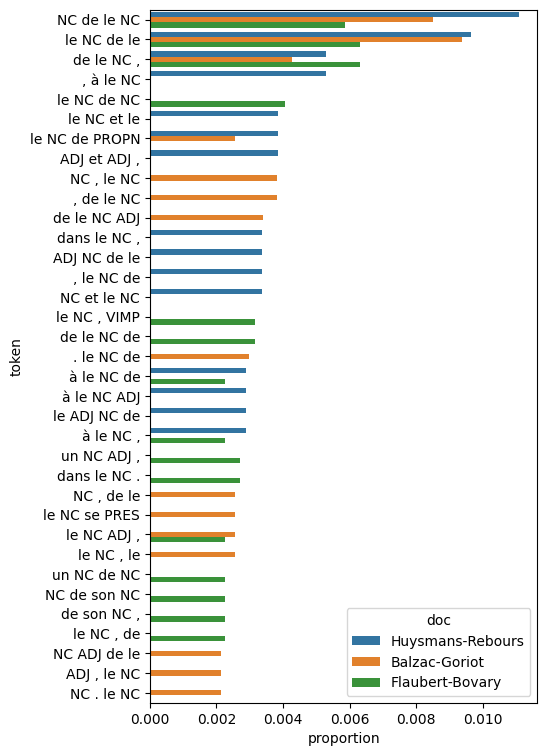

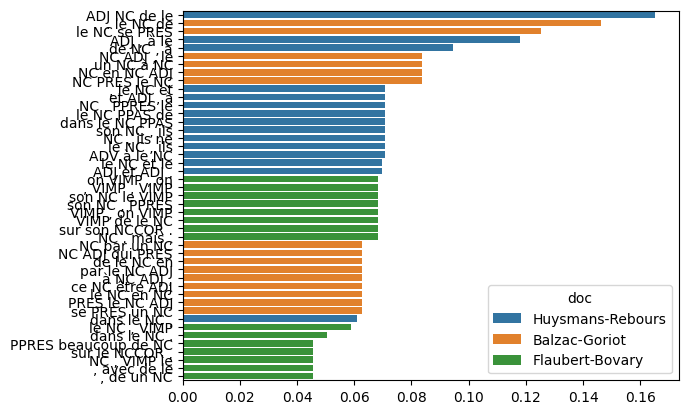

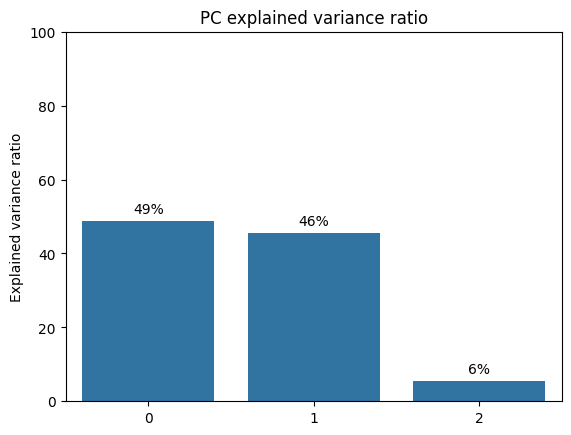

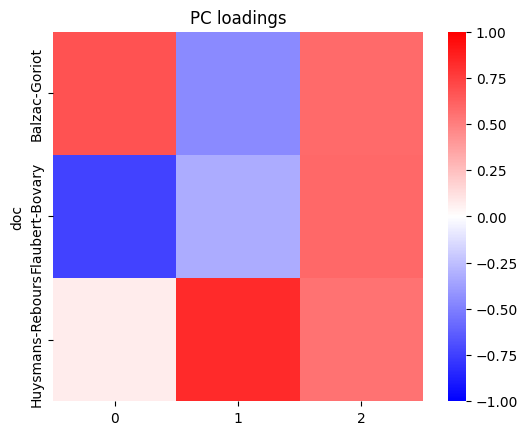

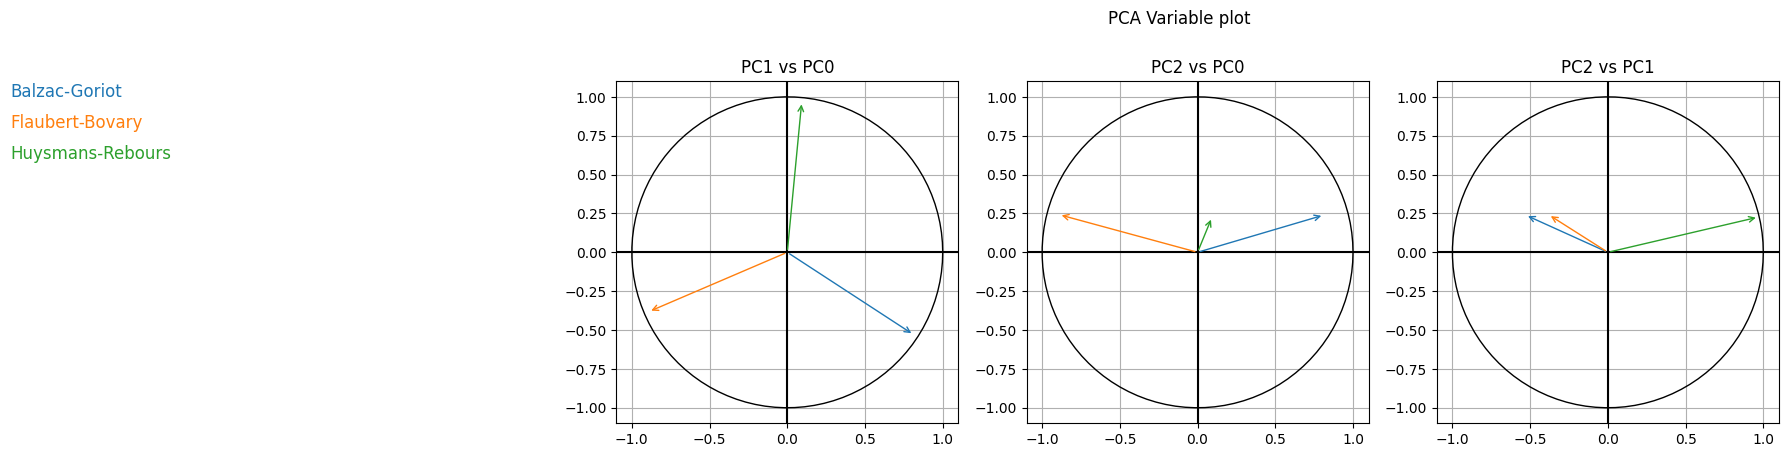

In [7]:
pipeline.execute(n=n, feature=feature, method="pca", plot=True, stat="proportion", n_tokens=15, plot_type="group")

# Specificity

In [8]:
from motifs.features import build_specificity
spec = build_specificity(pipeline.ngrams)

In [9]:
# Show the 10 most specific tokens for Balzac-Goriot:
doc = "Balzac-Goriot"
spec.sort_values(by=[doc, "spec"], ascending=False).head(10)

,Balzac-Goriot,Flaubert-Bovary,Huysmans-Rebours,doc,f,t,spec,rel_f
token,,,,,,,,
. le NC de,3.159675,0.000000,0.0,Balzac-Goriot,7,2349,3.159675,0.002980
le NC se PRES,2.707934,0.000000,0.0,Balzac-Goriot,6,2349,2.707934,0.002554
"NC ADJ , le",1.804811,0.000000,0.0,Balzac-Goriot,4,2349,1.804811,0.001703
NC PRES le NC,1.804811,0.000000,0.0,Balzac-Goriot,4,2349,1.804811,0.001703
NC en NC ADJ,1.804811,0.000000,0.0,Balzac-Goriot,4,2349,1.804811,0.001703
un NC à NC,1.804811,0.000000,0.0,Balzac-Goriot,4,2349,1.804811,0.001703
"ADJ , le NC",1.629711,-1.057628,0.0,Balzac-Goriot,5,2349,1.629711,0.002129
"ADJ , le NC",1.629711,-1.057628,0.0,Flaubert-Bovary,1,2213,-1.057628,0.000452
NC . ce NC,1.353429,0.000000,0.0,Balzac-Goriot,3,2349,1.353429,0.001277


It seems that in Goriot, Balzac often starts a sentence with "le NC de". This motifs are highly specific to Balzac-Goriot with an index of 3.15 and appearing 7 times, respectively. It is not represented in Flaubert-Bovary or Huysmans-Rebours.

# Top down analysis


We have identified a very specific motif ". le NC de" in Balzac-Goriot. Let us understand patterns in the original texts around this motif.

## Cooccurrence

First, it is important to check which motifs occur with the selected motif.

The analysis of cooccurrence is done at a context level. Thus we must transform the n-grams text into windows of n-grams of arbitrary length. For this, we use the `build_window_corpus`. For example, we can set the context length to 2 to check the immediate coocurrence (left and right).

Then we find the cooccurrent tokens with `find_cooccurrent_token`.

In [10]:
# Transform to context data frame
from motifs.utils import build_window_corpus
from motifs.metrics import find_cooccurrent_tokens

windows = build_window_corpus(pipeline.ngrams, 3)

# Within a single text
token = ". le NC de"
tokens = find_cooccurrent_tokens(
    token, windows[windows.doc == doc], 30
)
tokens

,target,token,count
0,. le NC de,NC de ce NC,1
1,. le NC de,NC de entre le,1
2,. le NC de,NC de le NC,1
3,. le NC de,elles . le NC,1
4,. le NC de,le NC . le,1
5,. le NC de,entre elles . le,1
6,. le NC de,le NC de ce,1
7,. le NC de,le NC de entre,1
8,. le NC de,son NC . le,1
9,. le NC de,le NC de le,2


We observe that the most cooccurrent token of ". le NC de" is "NC . le NC" that is we find that "NC . le NC de" seems to be an important motif in Balzac-Goriot. Balzac often finished a sentence with a common noun and starts a new one with "le NC de".

We can also check the cooccurrence of the motif at the corpus level without filtering, using `corpus_cooccurrent_tokens`

In [11]:
# At the corpus level
from motifs.metrics import corpus_cooccurrent_tokens
cooccurent_tokens = corpus_cooccurrent_tokens(token, windows, 10)
cooccurent_tokens

,target,token,count,doc
0,. le NC de,NC de entre le,1,Balzac-Goriot
1,. le NC de,NC de le NC,1,Balzac-Goriot
2,. le NC de,elles . le NC,1,Balzac-Goriot
3,. le NC de,le NC . le,1,Balzac-Goriot
4,. le NC de,entre elles . le,1,Balzac-Goriot
5,. le NC de,le NC de ce,1,Balzac-Goriot
6,. le NC de,le NC de entre,1,Balzac-Goriot
7,. le NC de,son NC . le,1,Balzac-Goriot
8,. le NC de,le NC de le,2,Balzac-Goriot
9,. le NC de,NC . le NC,3,Balzac-Goriot


We do not find cooccurences outside Balzac-Goriot, which was expected.

## Return-to-text

It is worth looking into the original text to understand how the motif is used.

For this we use the `return_to_text_from_token` function with a context length of 5 tokens, as it follows:

In [12]:
from motifs.utils import return_to_text_from_token
context_len = 5
context = return_to_text_from_token(pipeline.ngrams, token, n, context_len)
context

,left_context,text,right_context,doc,token
0,? le doute est permis,. Les particularités de,cette scène pleine d' observations,Balzac-Goriot,. le NC de
1,un fruit savoureux promptement dévoré,. Le char de,"la civilisation , semblable à",Balzac-Goriot,. le NC de
2,voyez coupée dans sa profondeur,. Le long de,"cette façade , entre la",Balzac-Goriot,. le NC de
3,ses conversations avec les pensionnaires,. Le long de,"chaque muraille , règne une",Balzac-Goriot,. le NC de
4,leurs lignes jurent entre elles,. La profondeur de,cette maison comporte deux croisées,Balzac-Goriot,. le NC de
5,lambrissée à hauteur d' appui,. Le surplus de,les parois est tendu d',Balzac-Goriot,. le NC de
6,les classiques personnages sont coloriés,. Le panneau d',entre les croisées grillagées offre,Balzac-Goriot,. le NC de


# Bottom up analysis

## Cooccurrence

For example, we can find the top $n$ coocurrent motif within a single document like Balzac-Goriot with `find_top_n_cooccurrence`. We use $n=5$ in the example below:

In [13]:
# Within a single text
from motifs.metrics import find_top_n_cooccurrence
cooc = find_top_n_cooccurrence(windows[windows.doc == doc], 5)
cooc

,token1,token2,count
0,"de le NC ,","le NC , de",3
1,et le NC de,le NC de le,3
2,"ADJ , le NC","NC ADJ , le",4
3,"NC , le NC","le NC , le",5
4,NC de le NC,le NC de le,12


We find that the most cooccurrent motifs with a window of length 5 for 4-grams are "NC de le NC" and "le NC de le".

## Specificity

For example, we can check the original text for the most specific tokens in the corpus with the function `return_to_text_from_spec`. To only return a reasonable number of tokens, we apply a filter on the tokens. We return the tokens that have a minimum specificity of 1 (`min_spec=1`) and a minimum frequency of 2 (`min_freq=2`, default behavior).

In [14]:
from motifs.utils import return_to_text_from_spec
import time
t1 = time.time()
context = return_to_text_from_spec(pipeline.ngrams, spec, n, context_len, min_spec=1, min_freq=2)
t2 = time.time()
print(t2-t1)
context

0.2798960208892822


,left_context,text,right_context,doc,spec,f,t
token,,,,,,,
ADJ NC de le,l' arc bombé remplissait l',énorme coquille de les,cuirasses . Ceux -là étaient,Huysmans-Rebours,3.538711,7,2074
ADJ NC de le,l' un de les plus,intimes familiers de le,duc d' Épernon et de,Huysmans-Rebours,3.538711,7,2074
ADJ NC de le,efforça de lui apprendre les,premiers éléments de les,sciences . Sa famille se,Huysmans-Rebours,3.538711,7,2074
ADJ NC de le,la nuit factice dont les,épais rideaux de les,croisées enveloppaient la chambre .,Huysmans-Rebours,3.538711,7,2074
ADJ NC de le,à le diriger sur les,profitables carrières de les,écoles ; bien qu' il,Huysmans-Rebours,3.538711,7,2074
...,...,...,...,...,...,...,...
", à le NC",ressemblait à l' antique aïeul,", à le mignon",", dont il avait la",Huysmans-Rebours,-2.049232,2,2349
", à le NC","fièvres , elle parvint cependant",", à l' aide",de grand air et de,Huysmans-Rebours,-2.049232,2,2349
", à le NC",se couchait dans la prairie,", à l' ombre","de les hautes meules ,",Huysmans-Rebours,-2.049232,2,2349


For Balzac-Gortio, we foudn again the motif ". le NC de".

In [15]:
context[context["doc"] == "Balzac-Goriot"]

,left_context,text,right_context,doc,spec,f,t
token,,,,,,,
. le NC de,? le doute est permis,. Les particularités de,cette scène pleine d' observations,Balzac-Goriot,3.159675,7,2349
. le NC de,un fruit savoureux promptement dévoré,. Le char de,"la civilisation , semblable à",Balzac-Goriot,3.159675,7,2349
. le NC de,voyez coupée dans sa profondeur,. Le long de,"cette façade , entre la",Balzac-Goriot,3.159675,7,2349
. le NC de,ses conversations avec les pensionnaires,. Le long de,"chaque muraille , règne une",Balzac-Goriot,3.159675,7,2349
. le NC de,leurs lignes jurent entre elles,. La profondeur de,cette maison comporte deux croisées,Balzac-Goriot,3.159675,7,2349
...,...,...,...,...,...,...,...
"NC , le NC",le vernis écaillé qui la,"couvre , les amateurs",de symboles y découvriraient peut-être,Balzac-Goriot,-1.867152,2,2213
"NC , le NC",pension . Elle sent le,"renfermé , le moisi",", le rance ; elle",Balzac-Goriot,-1.867152,2,2213
"NC , le NC","sent le renfermé , le","moisi , le rance","; elle donne froid ,",Balzac-Goriot,-1.867152,2,2213
